# 時系列予測実行例

元コード：https://github.com/h2oai/driverlessai-tutorials/blob/master/driverlessai_experiments/timeseries/walmart_timeseries_experiment/training_timeseries_model.ipynb

In [83]:
import pandas as pd
import driverlessai
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score, mean_squared_error

### ローカルでのデータ準備

データはDriverlessAIサーバの`/data/TimeSeries/walmart/`配下

In [27]:
sales_data = pd.read_csv("../tmp/walmart_train.csv")
print(sales_data.shape)
sales_data.head()

(421570, 15)


,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,sample_weight
0,1,1,2010-02-05,24924.50,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,0,1
1,1,2,2010-02-05,50605.27,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,0,1
2,1,3,2010-02-05,13740.12,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,0,1
3,1,4,2010-02-05,39954.04,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,0,1
4,1,5,2010-02-05,32229.38,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,0,1


In [28]:
print(sales_data["Date"].nunique())
print(sales_data["Store"].nunique())
print(sales_data["Dept"].nunique())

143
45
81


In [29]:
143*45*81

521235

In [30]:
# Convert Date column to datetime
sales_data["Date"] = pd.to_datetime(sales_data["Date"], format="%Y-%m-%d")

In [31]:
sales_data.dtypes

Store                     int64
Dept                      int64
Date             datetime64[ns]
Weekly_Sales            float64
Temperature             float64
Fuel_Price              float64
MarkDown1               float64
MarkDown2               float64
MarkDown3               float64
MarkDown4               float64
MarkDown5               float64
CPI                     float64
Unemployment            float64
IsHoliday                 int64
sample_weight             int64
dtype: object

In [32]:
sales_data["Date"].unique()[:6]    # 週次データ

array(['2010-02-05T00:00:00.000000000', '2010-02-12T00:00:00.000000000',
       '2010-02-19T00:00:00.000000000', '2010-02-26T00:00:00.000000000',
       '2010-03-05T00:00:00.000000000', '2010-03-12T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [33]:
# Temperature, Fuel_Price, CPI, Unemploymentは、予測時点で情報が利用できない、１週過去情報を予測に用いるため、１週分シフトさせる
lag_variables = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
dai_data = sales_data.set_index(["Date", "Store", "Dept"])
lagged_data = dai_data.loc[:, lag_variables].groupby(level=["Store", "Dept"]).shift(1)

# Join lagged predictor variables to training data
dai_data = dai_data.join(lagged_data.rename(columns=lambda x: x +"_lag"))

# Drop original predictor variables - we do not want to use these in the model 
dai_data = dai_data.drop(lagged_data, axis=1)
dai_data = dai_data.reset_index()
dai_data.shape

(421570, 15)

In [34]:
# 加工済みモデリングデータ

dai_data.head()

,Date,Store,Dept,Weekly_Sales,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,sample_weight,Temperature_lag,Fuel_Price_lag,CPI_lag,Unemployment_lag
0,2010-02-05,1,1,24924.50,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,NaN,NaN,NaN,NaN
1,2010-02-05,1,2,50605.27,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,NaN,NaN,NaN,NaN
2,2010-02-05,1,3,13740.12,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,NaN,NaN,NaN,NaN
3,2010-02-05,1,4,39954.04,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,NaN,NaN,NaN,NaN
4,2010-02-05,1,5,32229.38,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,NaN,NaN,NaN,NaN


In [35]:
print( dai_data["Date"].min() )
print( dai_data["Date"].max() )

2010-02-05 00:00:00
2012-10-26 00:00:00


In [36]:
train_data = dai_data.loc[dai_data["Date"] < "2012-10-26"]
print(train_data.shape)
test_data = dai_data.loc[dai_data["Date"] == "2012-10-26"]    # 最終週のみをテストデータとする
print(test_data.shape)

(418611, 15)
(2959, 15)


In [37]:
# train_data, test_dataを、サーバへアップするため、ローカルへ一時保存

train_path = "../tmp/wm_train_data.csv"
test_path = "../tmp/wm_test_data.csv"

train_data.to_csv(train_path, index = False)
test_data.to_csv(test_path, index = False)

### Driverless AIサーバでのモデル作成、予測の実施

In [39]:
# Driverless AIのuser nameとpasswordの読み込み
import json
with open('../idpass.json') as f:
    idpass = json.load(f)

In [71]:
# Driverless AIサーバーへの接続
dai = driverlessai.Client(address='http://34.203.218.123:12345', username=idpass['id'], password=idpass['pass1921'])
dai

<class 'driverlessai._core.Client'> http://34.203.218.123:12345

In [43]:
# ローカルのデータをDriverless AIサーバへアップ
train_dai = dai.datasets.create(train_path, force=True)
test_dai = dai.datasets.create(test_path, force=True)

Complete 100.00% - [4/4] Computed stats for column Dept
Complete 100.00% - [4/4] Computed stats for column Unemployment_lag


Experiments.create
- Launch an experiment on the Driverless AI server and wait for it to complete before returning.
- http://docs.h2o.ai/driverless-ai/pyclient/docs/html/client.html#driverlessai._experiments.Experiments

In [73]:
# Experimentの実施

settings = {
    'test_dataset': test_dai,
    'time_column': "Date",
    'time_groups_columns': ["Store", "Dept"],
    'num_prediction_periods': 1,
    'num_gap_periods': 0,
    'accuracy': 5,
    'time': 3,
    'interpretability': 8,
    'drop_columns': ["sample_weight"],
    'scorer': "RMSE",
}

experiment = dai.experiments.create(train_dataset=train_dai,
                                    target_column="Weekly_Sales",
                                    task='regression',
                                    force=True,
                                    **settings
                                   )

Experiment launched at: http://34.203.218.123:12345/#/experiment?key=cd608c3e-b442-11eb-a33c-0242ac110002
Complete 100.00% - Status: Complete                                                       


Experimentオブジェクト
- http://docs.h2o.ai/driverless-ai/pyclient/docs/html/objects.html#experiment

In [74]:
experiment.is_complete()

True

In [75]:
experiment.summary()

Status: Complete
Experiment: gopifavo (cd608c3e-b442-11eb-a33c-0242ac110002)
  Version: 1.9.2.1, 2021-05-13 23:56
  Settings: 5/3/8, seed=552192432, GPUs disabled
  Train data: wm_train_data.csv (418611, 14)
  Validation data: N/A
  Test data: [Test] (2959, 13)
  Target column: Weekly_Sales (regression)
System specs: Docker/Linux, 31 GB, 8 CPU cores, 0/0 GPU
  Max memory usage: 7.26 GB, 0 GB GPU
Recipe: AutoDL (34 iterations, 4 individuals)
  Validation scheme: time-based, 3 internal holdouts
  Feature engineering: 522 features scored (20 selected)
Timing: MOJO latency: 0.23058 millis (177.4MB)
  Data preparation: 11.09 secs
  Shift/Leakage detection: 15.92 secs
  Model and feature tuning: 850.68 secs (61 models trained)
  Feature evolution: 452.13 secs (75 of 372 models trained)
  Final pipeline training: 191.38 secs (1 model trained)
  Python / MOJO scorer building: 41.45 secs / 138.27 secs
Validation score: RMSE = 22721.92 (constant preds of 1.598e+04)
Validation score: RMSE = 5061.

In [76]:
experiment.metrics()

{'scorer': 'RMSE',
 'val_score': 5041.86669921875,
 'val_score_sd': 0.0009765625,
 'val_roc_auc': None,
 'val_pr_auc': None,
 'test_score': 2414.061279296875,
 'test_score_sd': 0.0009765625,
 'test_roc_auc': None,
 'test_pr_auc': None}

In [77]:
experiment.variable_importance()

gain,interaction,description
1,11_TargetLag:Date:Dept:Store.1,"Lag of target for groups ['Dept', 'Store'] by 1 time period"
0.627939,11_TargetLag:Date:Dept:Store.2,"Lag of target for groups ['Dept', 'Store'] by 2 time periods"
0.600206,11_TargetLag:Date:Dept:Store.3,"Lag of target for groups ['Dept', 'Store'] by 3 time periods"
0.230629,11_TargetLag:Date:Dept:Store.4,"Lag of target for groups ['Dept', 'Store'] by 4 time periods"
0.0304164,11_TargetLag:Date:Dept:Store.9,"Lag of target for groups ['Dept', 'Store'] by 9 time periods"
0.0195279,11_TargetLag:Date:Dept:Store.52,"Lag of target for groups ['Dept', 'Store'] by 52 time periods"
0.0154588,20_IsHoliday,IsHoliday (Original)
0.0139658,11_TargetLag:Date:Dept:Store.8,"Lag of target for groups ['Dept', 'Store'] by 8 time periods"
0.00855763,16_Date:Date~get_week,Week extracted from 'Date'
0.00733516,11_TargetLag:Date:Dept:Store.13,"Lag of target for groups ['Dept', 'Store'] by 13 time periods"


【Experiment完了画面】
<img src="img/TS_2021-05-14.png" width=800px>

#### テストデータに対する予測

In [78]:
# テストデータに対する予測
prediction = experiment.predict(dataset=test_dai, include_columns=train_data.columns.values.tolist())

Complete


In [79]:
# 予測結果をローカルへダウンロード
save_path = '../tmp/wm_test_data_RES.csv'

prediction.download(dst_dir='.', dst_file=save_path, overwrite=True)

Downloaded '../tmp/wm_test_data_RES.csv'


'../tmp/wm_test_data_RES.csv'

### ローカルでの結果確認

In [80]:
res = pd.read_csv(save_path)
print(res.shape)
res.head()

(2959, 18)


,Date,Store,Dept,Weekly_Sales,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,sample_weight,Temperature_lag,Fuel_Price_lag,CPI_lag,Unemployment_lag,Weekly_Sales.predicted,Weekly_Sales.predicted.lower,Weekly_Sales.predicted.upper
0,2012-10-26,1,1,27390.81,2585.85,31.75,6.0,1057.16,1305.01,0,1,67.97,3.594,223.425723,6.573,27709.934,12767.029875,36433.487781
1,2012-10-26,1,2,43134.88,2585.85,31.75,6.0,1057.16,1305.01,0,1,67.97,3.594,223.425723,6.573,43491.008,39208.184938,47413.414812
2,2012-10-26,1,3,9350.90,2585.85,31.75,6.0,1057.16,1305.01,0,1,67.97,3.594,223.425723,6.573,9692.794,5915.586992,19053.486758
3,2012-10-26,1,4,36292.60,2585.85,31.75,6.0,1057.16,1305.01,0,1,67.97,3.594,223.425723,6.573,34812.742,31014.132901,38665.401488
4,2012-10-26,1,5,25846.94,2585.85,31.75,6.0,1057.16,1305.01,0,1,67.97,3.594,223.425723,6.573,23122.365,13390.530703,32352.630156


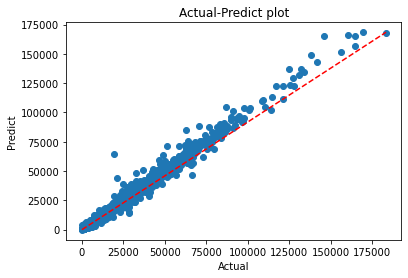

In [93]:
#plt.figure(figsize=(5, 5))
plt.scatter(res['Weekly_Sales'], res['Weekly_Sales.predicted'])
plt.plot([0, max(res['Weekly_Sales'],)],[0, max(res['Weekly_Sales.predicted'])], 'r--',)
plt.title('Actual-Predict plot')
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

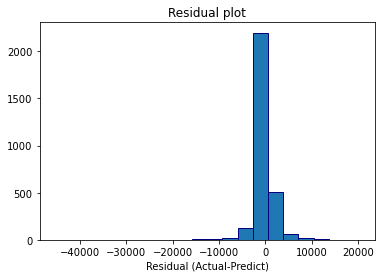

In [92]:
resid = res['Weekly_Sales'] - res['Weekly_Sales.predicted']

plt.hist(resid, bins=20, ec='navy')
plt.title('Residual plot')
plt.xlabel('Residual (Actual-Predict)')
plt.show()

In [84]:
# R2 
r2_score(res['Weekly_Sales'], res['Weekly_Sales.predicted'])

0.9869410118187198

In [85]:
# RMSE
mean_squared_error(res['Weekly_Sales'], res['Weekly_Sales.predicted'], squared=False)

2414.0613229571354